# Practical Application III: Comparing Classifiers

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Understanding the Data

the data are  related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts

### Read in the Data & Make Feature group

After we analize data we are going to rename column with prefix, so that can be simply identify the group, but dont loose the link.
Finding the following groups:
client_XXXX; contact_XXXX; campaign_XXXX; context_XXXX; target_XXXX

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time

In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# Adding prefixes to columns
df.rename(columns={
    'age': 'client_age',
    'job': 'client_job',
    'marital': 'client_marital',
    'education': 'client_education',
    'default': 'client_default',
    'housing': 'client_housing',
    'loan': 'client_loan',
    'contact': 'contact_type',
    'month': 'contact_month',
    'day_of_week': 'contact_day_of_week',
    'duration': 'contact_duration',
    'campaign': 'campaign_contacts',
    'pdays': 'campaign_pdays',
    'previous': 'campaign_previous_contacts',
    'poutcome': 'campaign_poutcome',
    'emp.var.rate': 'context_emp_var_rate',
    'cons.price.idx': 'context_cons_price_idx',
    'cons.conf.idx': 'context_cons_conf_idx',
    'euribor3m': 'context_euribor3m',
    'nr.employed': 'context_nr_employed',
    'y': 'target_subscribed_term_deposit'
}, inplace=True)

###  Understanding the Features

1) we look for **null/NaN value**: the result is no null or NaN value
2) analyze **target variable with a frequency plot**: target_subscribed_term_deposit, the dataset is really unbalanced
3) analyze data by visualization with frequency plot of features:
  - 3.1) a lot of not existent information - previous_contact; poutcome
  - 3.2) the customers are **mostly new customers**; a small percentage is from past campaigns
  - 3.3) the age is distributed across a wide range, but most are under 60
  - 3.4) **unknown value** present in job, marital, education, default, housing, loan
    - 3.4.1) **features with "unknown" value** and its impact on target = y - found that it impacts less than 30% of the dataset and does not impact "yes" for the target, so we consider it can be deleted. In fact, the highest number of non-existent values is for default, and with "unknown" on default, the target is "no". Maybe this information is fundamental to prioritize or not some calls to the customer.
  - 3.5) from features description we find out that **feature named "duration"** is good to use just for benchmarking but not to predict, so maybe it can be disregarded.
  - 5.6) default have information only for no or "not existent" --- so for our analisys add just complexity but not value added can be dropped



In [4]:
df.info()
print(df.isna().sum() > 0)
print(df.isnull().sum()> 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_age                      41188 non-null  int64  
 1   client_job                      41188 non-null  object 
 2   client_marital                  41188 non-null  object 
 3   client_education                41188 non-null  object 
 4   client_default                  41188 non-null  object 
 5   client_housing                  41188 non-null  object 
 6   client_loan                     41188 non-null  object 
 7   contact_type                    41188 non-null  object 
 8   contact_month                   41188 non-null  object 
 9   contact_day_of_week             41188 non-null  object 
 10  contact_duration                41188 non-null  int64  
 11  campaign_contacts               41188 non-null  int64  
 12  campaign_pdays                  

<function matplotlib.pyplot.show(close=None, block=None)>

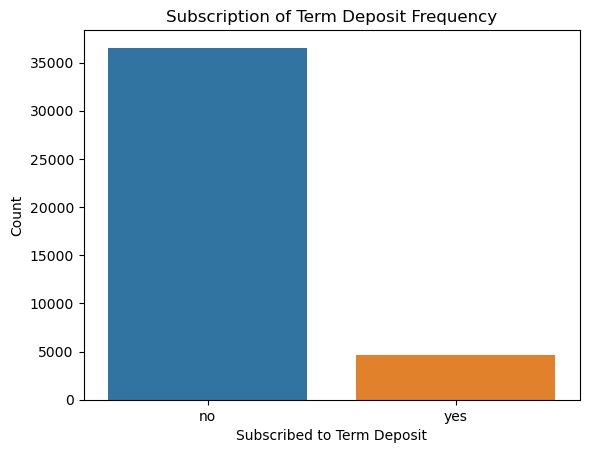

In [5]:
# Frequency plot: 
# Creare un grafico a barre della frequenza di 'target_subscribed_term_deposit'
sns.countplot(x='target_subscribed_term_deposit', data=df)

# Aggiungere titolo e etichette agli assi
plt.title('Subscription of Term Deposit Frequency')
plt.xlabel('Subscribed to Term Deposit')
plt.ylabel('Count')
plt.savefig('images/FreqTarget.jpg')
plt.show


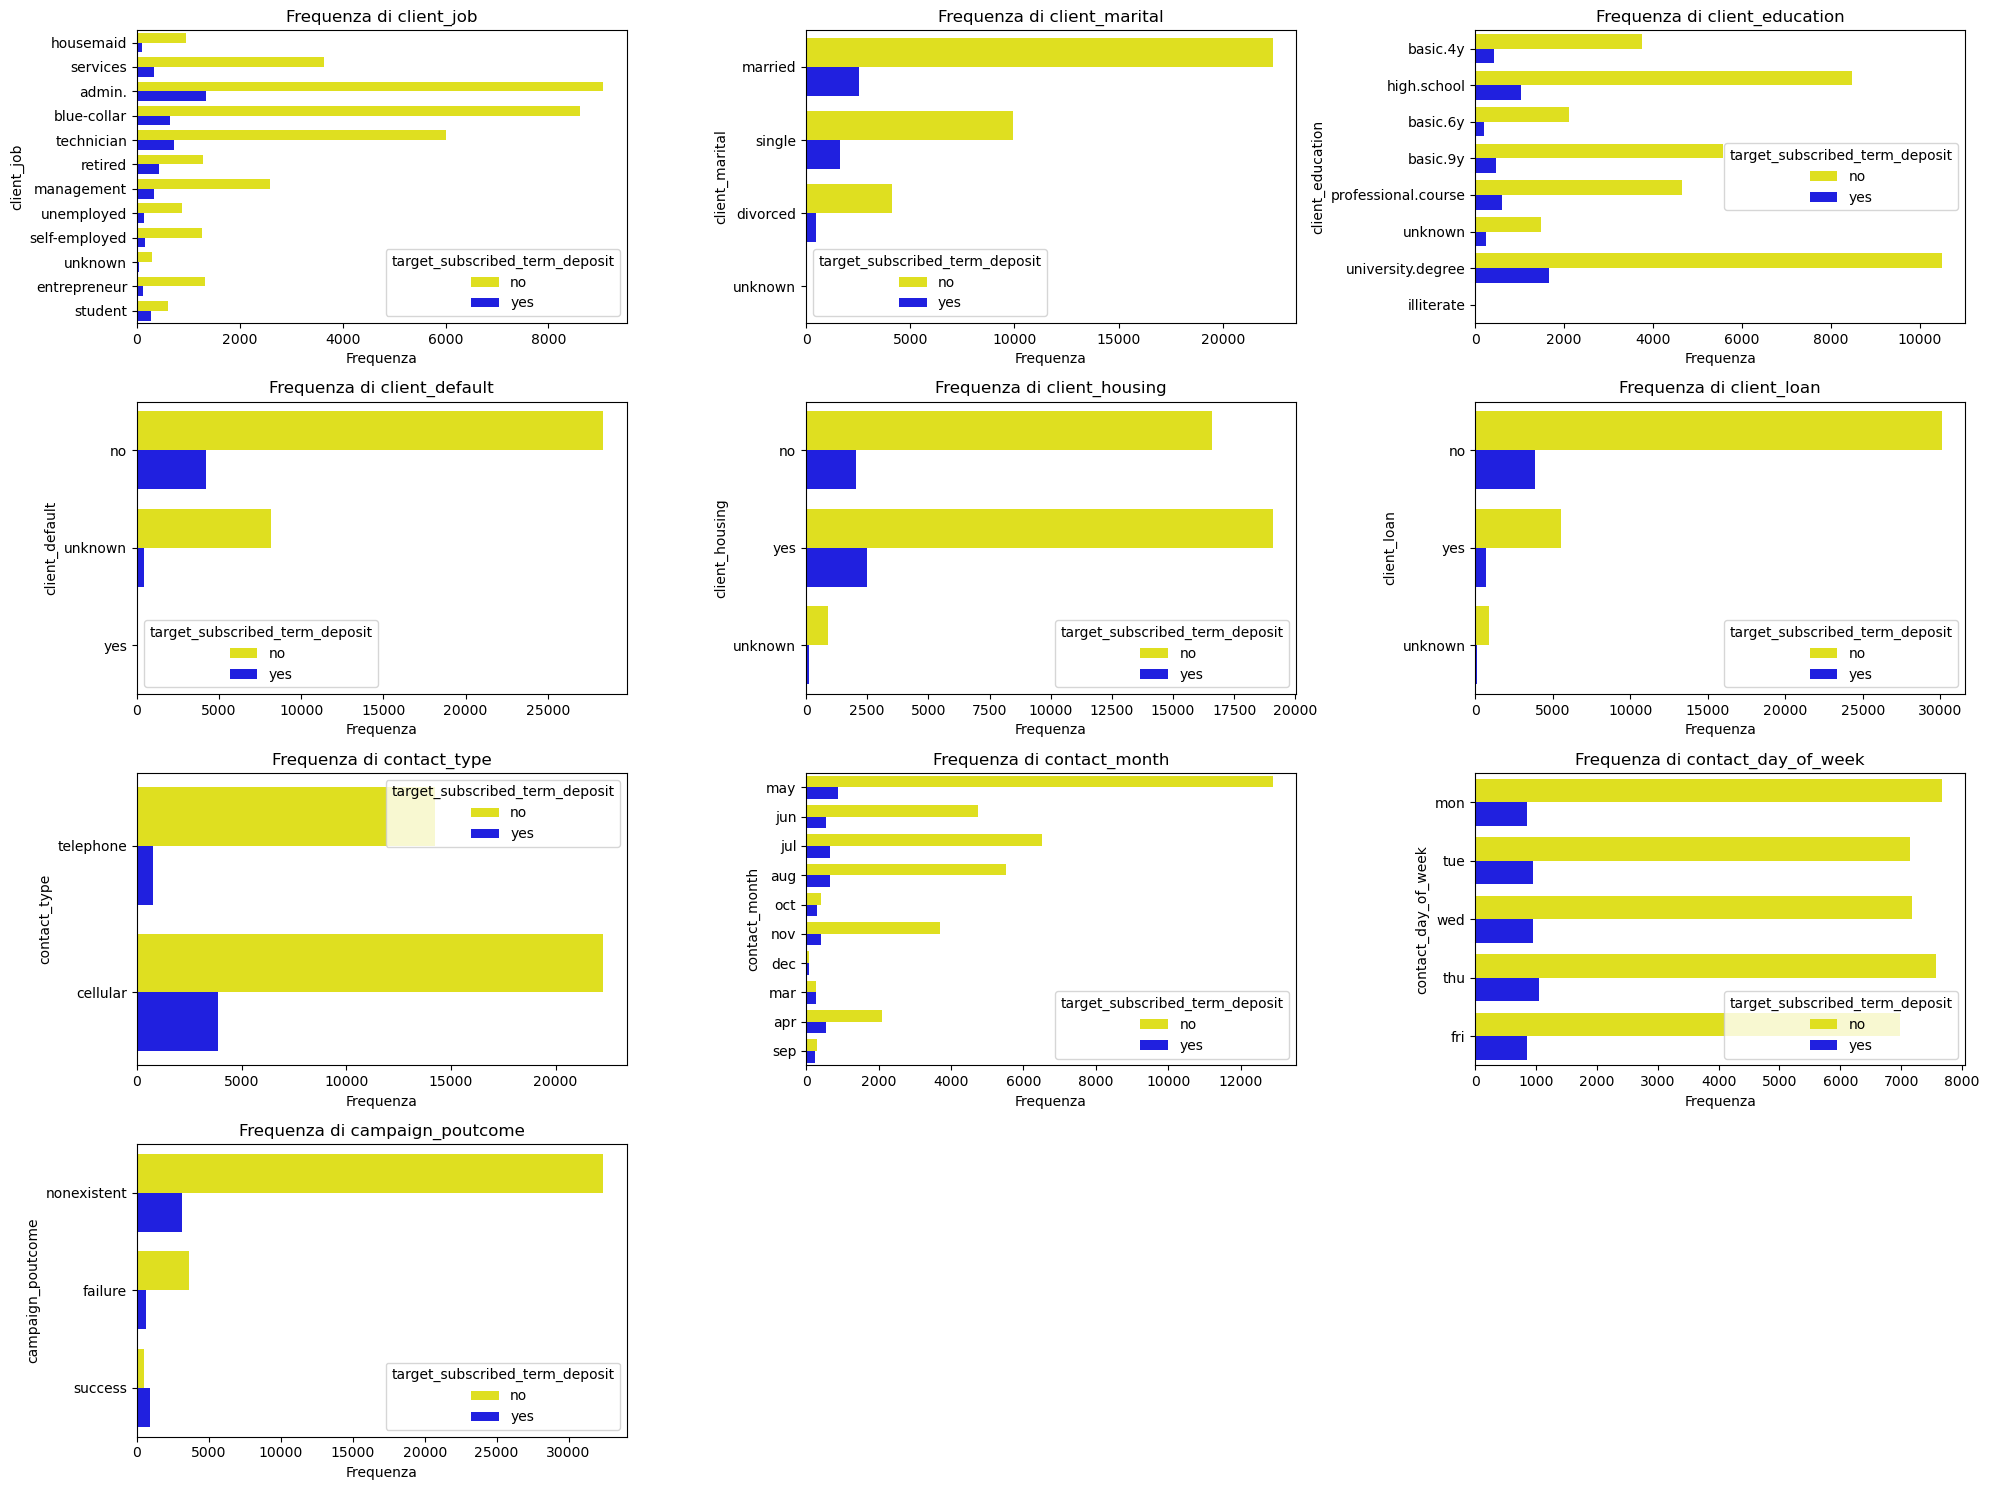

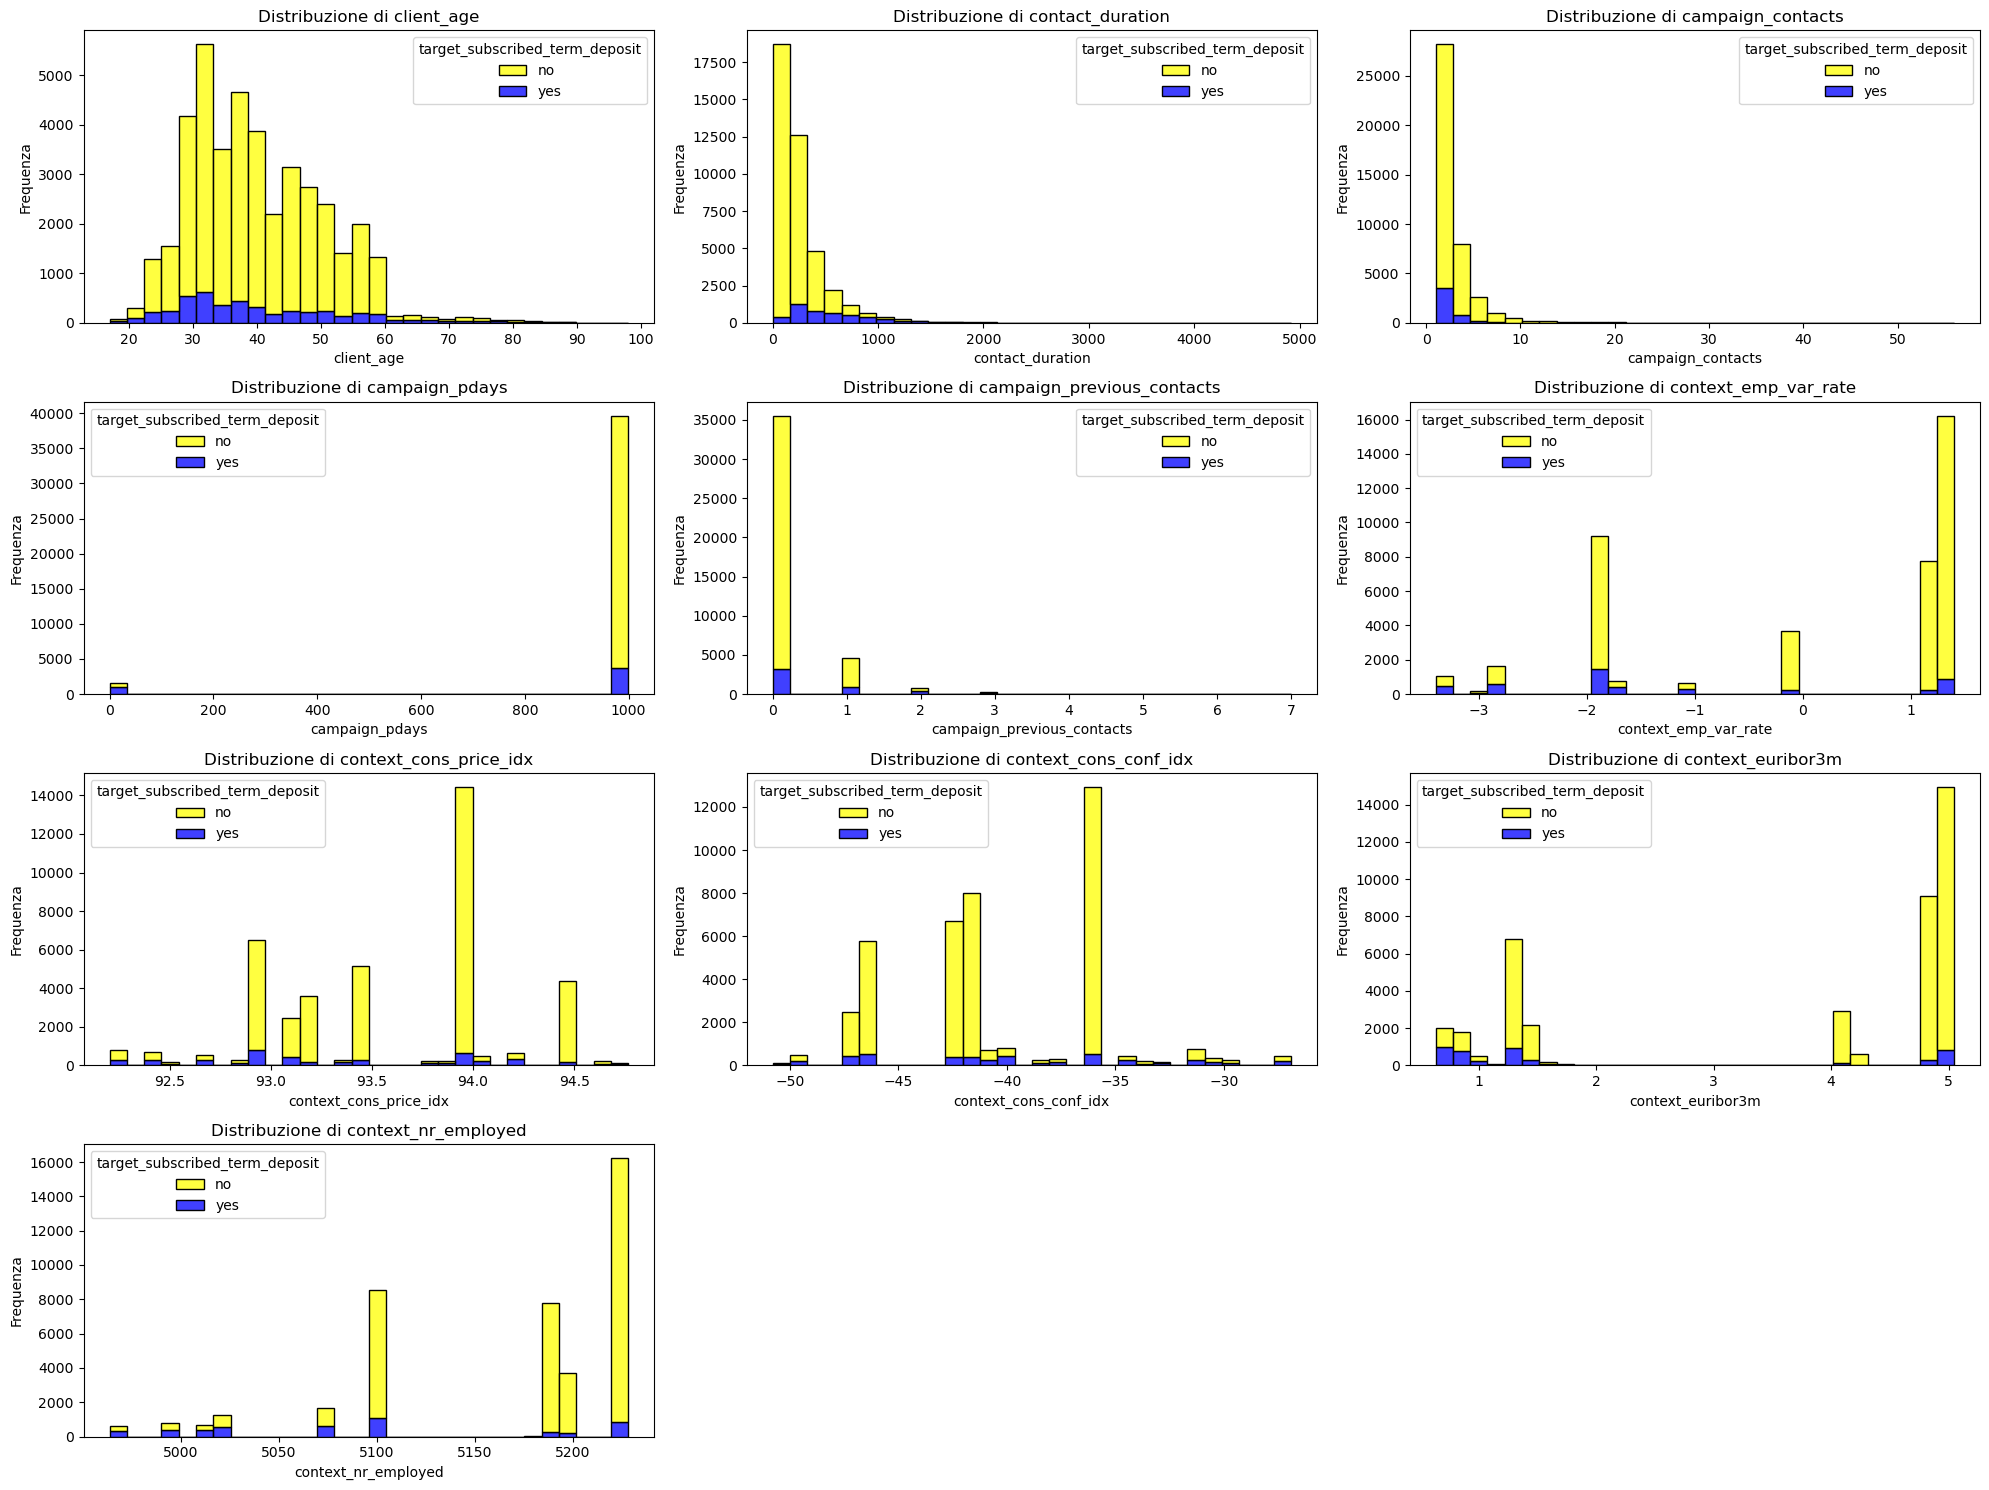

In [6]:
# Make frequency plot for each feature 


categorical_columns = df.select_dtypes(include=['object']).columns.drop('target_subscribed_term_deposit')

numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

yellow_blue_palette = {"yes": "blue", "no": "yellow"}

fig1, axes1 = plt.subplots(nrows=int(np.ceil(len(categorical_columns) / 3)), ncols=3, figsize=(20, 15))
axes1 = axes1.flatten()

for i, col in enumerate(categorical_columns):
    sns.countplot(y=col, hue='target_subscribed_term_deposit', data=df, ax=axes1[i], palette=yellow_blue_palette)
    axes1[i].set_title(f'Frequenza di {col}')
    axes1[i].set_ylabel(col)
    axes1[i].set_xlabel('Frequenza')

# Nasconde i subplot inutilizzati se ce ne sono
for j in range(i + 1, len(axes1)):
    fig1.delaxes(axes1[j])

plt.tight_layout()
plt.savefig('images/FreqFeaturesCategorical.jpg')
plt.show()

### For numerical features
fig2, axes2 = plt.subplots(nrows=int(np.ceil(len(numeric_columns) / 3)), ncols=3, figsize=(20, 15))
axes2 = axes2.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(df, x=col, hue='target_subscribed_term_deposit', bins=30, kde=False, multiple="stack", ax=axes2[i], palette=yellow_blue_palette)
    axes2[i].set_title(f'Distribuzione di {col}')
    axes2[i].set_xlabel(col)
    axes2[i].set_ylabel('Frequenza')

# Nasconde i subplot inutilizzati se ce ne sono
for j in range(i + 1, len(axes2)):
    fig2.delaxes(axes2[j])

plt.tight_layout()
plt.savefig('images/FreqFeaturesNumerical.jpg')
plt.show()



In [7]:
# Calculate percentage of "unknown" with reference to all dataset and also to "yes" target

categorical_columns = ['client_job', 'client_marital', 'client_education', 'client_default', 'client_housing', 'client_loan']

# Initialize an empty list to store results
unknown_analysis = []

# Loop through each categorical column
for col in categorical_columns:

    total_unknown = df[df[col] == 'unknown'].shape[0]
    
    percentage_unknown = (total_unknown / df.shape[0]) * 100
    
    unknown_and_target_1 = df[(df[col] == 'unknown') & (df['target_subscribed_term_deposit'] == 1)].shape[0]
    
    unknown_analysis.append({
        'Feature': col,
        'Total Unknown': total_unknown,
        'Percentage Unknown (%)': percentage_unknown,
        'Unknown and Target == 1': unknown_and_target_1
    })

unknown_df = pd.DataFrame(unknown_analysis)

print(unknown_df)

            Feature  Total Unknown  Percentage Unknown (%)  \
0        client_job            330                0.801204   
1    client_marital             80                0.194231   
2  client_education           1731                4.202680   
3    client_default           8597               20.872584   
4    client_housing            990                2.403613   
5       client_loan            990                2.403613   

   Unknown and Target == 1  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0  
5                        0  


### Understanding the Task - Business Objective

The goal is to increase investments, or in other words, improve the success rate of the marketing campaign. This requires identifying the features that have the greatest impact on the target audience, allowing us to reduce the number of contacts needed to achieve higher investment levels.

Our approach can be described as maximizing true positives (TP) on "yes" responses. However, since the cost of making a contact is relatively low compared to the potential return on investment, the best strategy might be to prioritize contacts predicted as true positives, even if it means sacrificing some precision. In this context, maximizing recall is important, even with a slightly lower precision rate, because making an extra phone call isn't a major issue if it helps capture a larger share of the investment opportunities.

## Engineering Features

to set a first model we are going to engineering a set of features and using that for the model, in particulare we are going to use the bank features that in our df are prefixed with client_

First of all we are asking if unknown value can be dropped -- our most objective is to understand what more impact on target = 1 and from previous section we saw that those value dont impact on 1 and are not a big percentage, considering also the df is unbalanced we try to drop and look which size we have. --- the result is eliminating about 26% of dataset so we decide to proceed.

After we will apply: StandardScaler for numeric features and OneHotEncoder (dropfirst) for categorical --- we tried to convert to numeric after the unknown dropping, but it would be the same result.

In [8]:
# Create df1 for bank and target features where we delete record with unknown information
prefix = 'client_'
prefix1 = 'target_'
df1 = df[[col for col in df.columns if col.startswith(prefix) or col.startswith(prefix1)]].copy()
categorical_features = df1.select_dtypes(include=['object']).columns
df1 = df1[~df1[categorical_features].apply(lambda x: x.str.contains('unknown')).any(axis=1)].copy()
df1 = df1.drop(columns=['client_default'])

In [9]:
# we go to encode data 

X = df1.drop(columns=['target_subscribed_term_deposit'], axis=1)
y = df1['target_subscribed_term_deposit']

numeric_features = X.select_dtypes(include=['int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

categorical_transformer = OneHotEncoder(drop='first' )
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

### Train/Test Split 
we use 20% for test 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### A Baseline Model

Referring to the defined business objective and considering the simplest metric, accuracy—defined as the percentage of correct predictions made by the model relative to the total number of examples or samples—we can observe that the dataset is highly imbalanced, with the target feature having 87% "no" and 13% "yes" responses. Therefore, using accuracy as the evaluation metric is not a good choice in this case.

To establish a more reliable baseline, I initially considered using Logistic Regression with default settings. However, the result was similar, meaning that for a simple model, we can consider Logistic Regression as our baseline.

In [11]:
# Try to calculate frequency to set a baseline

y_train_class_counts = y_train.value_counts()

most_frequent_class = y_train_class_counts.idxmax()

baseline_accuracy = y_train_class_counts[most_frequent_class] / len(y_train)

print(f"Most frequent class is: {most_frequent_class}")
print(f"Accuracy no: {baseline_accuracy:.2f}")

Most frequent class is: no
Accuracy no: 0.87


In [12]:
# Apply Simple model with logistic regression and standar parameter setting - to try to find a firs baseline for accuracy and recall

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
pipeline.fit(X_train,y_train)

y_pred = pipeline.predict(X_test)

model_accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy target no: {model_accuracy:.2f}")

precision = precision_score(y_test, y_pred, pos_label='yes')
recall = recall_score(y_test, y_pred, pos_label='yes')
f1 = f1_score(y_test, y_pred, pos_label='yes')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1: {f1:.2f}")

# Mostra la matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy target no: 0.87
Precision: 0.00
Recall: 0.00
F1: 0.00
Confusion Matrix:
[[5304    0]
 [ 794    0]]


C:\Users\gsepe\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### A Simple Model

Let's start by building a simple model and, once again, use Logistic Regression. However, in this case, we will add the option for class balancing and increase the number of iterations.

As a result, we observe lower accuracy scores, but they are more representative of the true performance. In fact, in this case, we also see improved values for Precision, Recall, and F1-score, which were not properly reflected in the previous model.

In [13]:
# Apply Logistic Regression with weight "balanced"


pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced',max_iter=1000, random_state=42))
])
pipeline.fit(X_train,y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['client_age'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['client_job', 'client_marital', 'client_education', 'client_housing',
       'client_loan'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [14]:
# Arrange the prediction and scoring to make analysis and plot

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
    
precision_train = precision_score(y_train, y_train_pred, pos_label='yes')
precision_test = precision_score(y_test, y_test_pred, pos_label='yes')
    
recall_train = recall_score(y_train, y_train_pred, pos_label='yes')
recall_test = recall_score(y_test, y_test_pred, pos_label='yes')
    
f1_train = f1_score(y_train, y_train_pred, pos_label='yes')
f1_test = f1_score(y_test, y_test_pred, pos_label='yes')

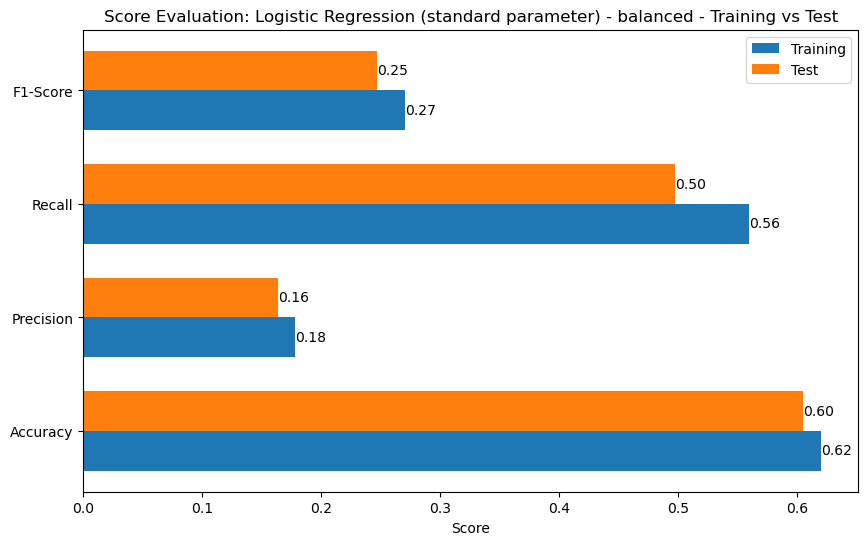

In [15]:
# Creating Plot to analyze scoring for balanced simple model

metrics = {
    'Accuracy': [train_accuracy, test_accuracy],
    'Precision': [precision_train, precision_test],
    'Recall': [recall_train, recall_test],
    'F1-Score': [f1_train, f1_test]
}


labels = ['Training', 'Test']
bar_width = 0.35  # Larghezza delle barre

index = np.arange(len(metrics))

fig, ax = plt.subplots(figsize=(10, 6))

train_bars = ax.barh(index - bar_width/2, [metrics[m][0] for m in metrics], bar_width, label='Training')
test_bars = ax.barh(index + bar_width/2, [metrics[m][1] for m in metrics], bar_width, label='Test')

ax.set_xlabel('Score')
ax.set_title('Score Evaluation: Logistic Regression (standard parameter) - balanced - Training vs Test')
ax.set_yticks(index)
ax.set_yticklabels(metrics.keys())
ax.legend()

for bar in train_bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

for bar in test_bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.savefig('images/ScoreEvaLogRegBalanced.jpg')
plt.show()

### Score the Model

We can define the accuracy of the model è 60% on a dataset more balaced. 
But more Recall 50% (scoring of our interest to optimize)

### Model Comparisons

Now, let's create a comparison between the models in terms of performance, focusing on the Logistic Regression model, the KNN algorithm, Decision Tree, and SVM models.

All models will be configured with default parameters, except for class balancing.

From the result we can say that:
- Decision Tree suffer about overfitting, we see a big difference between train and test scoring.
- Logistic Regression and SVM have the best result for recall 0.5 and 0.49 --- with low precision (this answer to our objectives)
- KNN remains less effective due to its very low recall (0.08 on the test set), while Decision Tree suffers from overfitting

So what we can conclude:
- Logistic Regression should be prioritized, as it has the highest recall (0.50) and avoids overfitting. It's a simple model that is effective in capturing positive cases even with imbalanced data.
- SVM is still a competitive option, with only a slightly lower recall (0.49), and may be worth tuning further. we can experiment with adjusting the C parameter to balance recall and precision, or try different kernels.

In [16]:
# Define models to apply and going to to fit pipeline for each

models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(class_weight='balanced',random_state=42)),
    ('SVM', SVC(class_weight='balanced', random_state=42))
]

results_accuracy = []
results_f1 = []

# Create the for cicle to apply each model
for model_name, model in models:

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    precision_train = precision_score(y_train, y_train_pred, pos_label='yes')
    precision_test = precision_score(y_test, y_test_pred, pos_label='yes')
    
    recall_train = recall_score(y_train, y_train_pred, pos_label='yes')
    recall_test = recall_score(y_test, y_test_pred, pos_label='yes')
    
    f1_train = f1_score(y_train, y_train_pred, pos_label='yes')
    f1_test = f1_score(y_test, y_test_pred, pos_label='yes')
    
    results_accuracy.append([model_name, train_time, train_accuracy, test_accuracy])
    results_f1.append([model_name, precision_train, precision_test, recall_train, recall_test, f1_train, f1_test])



In [17]:
# Create 2 df for results 
results_df = pd.DataFrame(results_accuracy, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy']).round(2)
results_df_added = pd.DataFrame(results_f1, columns=['Model', 'PRECISION TRAIN', 'PRECISION TEST', 'RECALL TRAIN', 'RECALL TEST','F1 Train', 'F1 Test']).round(2)

print(results_df)
print(results_df_added)

                 Model  Train Time  Train Accuracy  Test Accuracy
0  Logistic Regression        0.24            0.62           0.60
1                  KNN        0.11            0.88           0.86
2        Decision Tree        0.55            0.74           0.64
3                  SVM       44.70            0.64           0.61
                 Model  PRECISION TRAIN  PRECISION TEST  RECALL TRAIN  \
0  Logistic Regression             0.18            0.16          0.56   
1                  KNN             0.53            0.35          0.13   
2        Decision Tree             0.31            0.17          0.87   
3                  SVM             0.20            0.16          0.62   

   RECALL TEST  F1 Train  F1 Test  
0         0.50      0.27     0.25  
1         0.08      0.21     0.13  
2         0.45      0.45     0.24  
3         0.49      0.30     0.25  


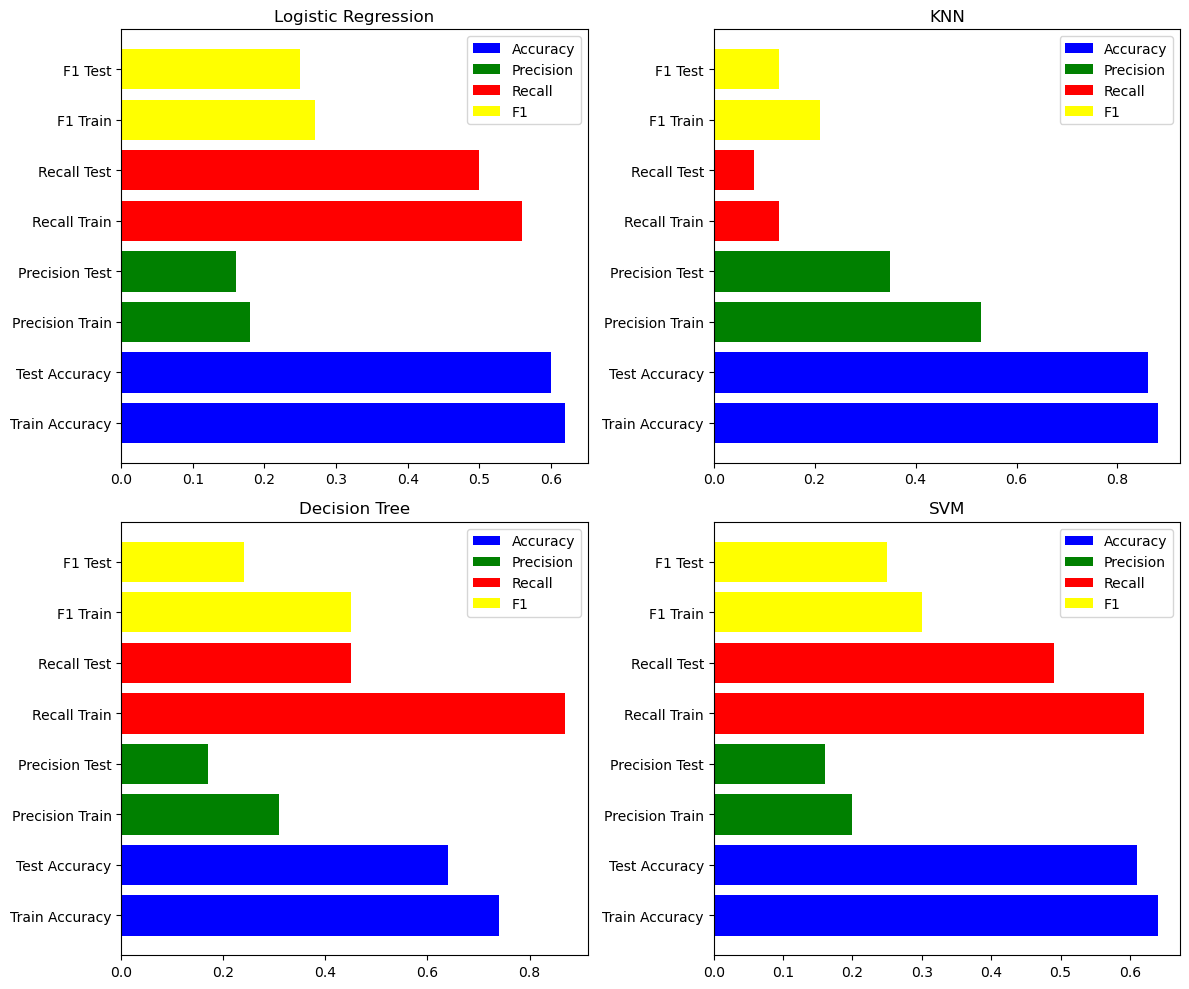

In [18]:
# Create a plot divided on 2x2 for comparison the scoring on different models applied


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Loop for each model
models = results_df['Model']
for i, model in enumerate(models):
    ax = axes[i // 2, i % 2]
    
    ax.barh(['Train Accuracy', 'Test Accuracy'], [results_df.iloc[i, 2], results_df.iloc[i, 3]], color='blue', label='Accuracy')
    
    ax.barh(['Precision Train', 'Precision Test'], [results_df_added.iloc[i, 1], results_df_added.iloc[i, 2]], color='green', label='Precision')

    ax.barh(['Recall Train', 'Recall Test'], [results_df_added.iloc[i, 3], results_df_added.iloc[i, 4]], color='red', label='Recall')
   
    ax.barh(['F1 Train', 'F1 Test'], [results_df_added.iloc[i, 5], results_df_added.iloc[i, 6]], color='yellow', label='F1')

    ax.set_title(f'{model}')
    
    ax.legend()

plt.tight_layout()
plt.savefig('images/ModelComparison.jpg')
plt.show()

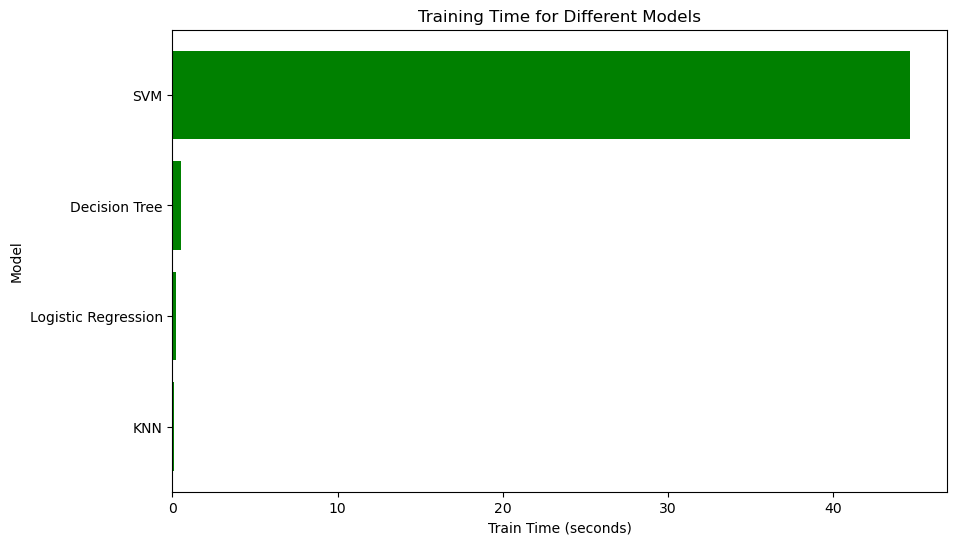

In [19]:
# Plot training time on the models comparison

results_df_sorted = results_df.sort_values(by='Train Time')


plt.figure(figsize=(10, 6))
plt.barh(results_df_sorted['Model'], results_df_sorted['Train Time'], color='green')


plt.xlabel('Train Time (seconds)')
plt.ylabel('Model')
plt.title('Training Time for Different Models')
plt.savefig('images/SimpleModelsTimeTrain.jpg')
plt.show()

### Improving the Model

1) Analize other features and correlation to identify relation with > 0.65:
- correlation analysis for numerical features;
- Cramér's V for chategorical features; 
**Result** 
strong relations on context features (>0.65), so we mantain only: context_emp_var_rate; context_cons_conf_idx and can *drop: context_cons_price_idx; context_euribor3m; context_nr_employed*
strong relation between housing and loan, so we *drop housing* and mantain more generic information with loan.

2) as described at start in features description we found that *duration can be dropped* for our scope.
3) we need to add what we make on the client (bank) information: *"unknowns" records dropped; default column dropped*.

4) Optimize SVM on recall:
- we need to try C = 1 and higher

5) Optimize Logistic Regression on recall: 
- setting various C value

6) drawing the plot of scores we find out no overfitting and good result for recall.



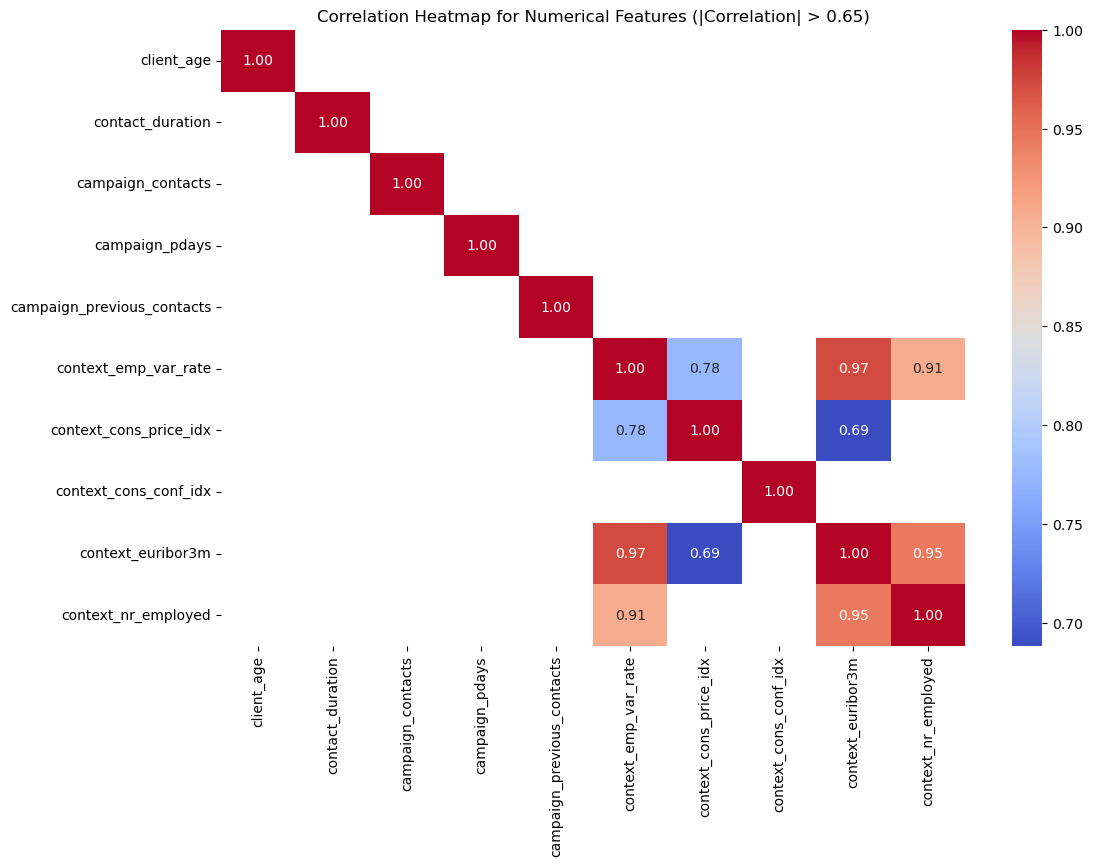

Feature pairs with correlation greater than 0.65:
context_emp_var_rate and context_cons_price_idx: 0.78
context_emp_var_rate and context_euribor3m: 0.97
context_emp_var_rate and context_nr_employed: 0.91
context_cons_price_idx and context_euribor3m: 0.69
context_euribor3m and context_nr_employed: 0.95


In [20]:
# correlation analysis for numerical features with correlation matrix

numerical_features = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numerical_features.corr()

# Create a mask to display only correlations with absolute values > 0.65
mask = (abs(corr_matrix) > 0.65)

# Plot the correlation heatmap for values with absolute correlation > 0.65
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=~mask, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Heatmap for Numerical Features (|Correlation| > 0.65)')
plt.savefig('images/corr_NumericalFeat.jpg')
plt.show()



# Extract feature pairs with correlation > 0.65
strong_corr_pairs = []

for i in range(corr_matrix.shape[0]):
    for j in range(i + 1, corr_matrix.shape[1]):
        if abs(corr_matrix.iloc[i, j]) > 0.65:
            feature_1 = corr_matrix.index[i]
            feature_2 = corr_matrix.columns[j]
            correlation_value = corr_matrix.iloc[i, j]
            strong_corr_pairs.append((feature_1, feature_2, correlation_value))

print("Feature pairs with correlation greater than 0.65:")
for feature_1, feature_2, correlation_value in strong_corr_pairs:
    print(f"{feature_1} and {feature_2}: {correlation_value:.2f}")

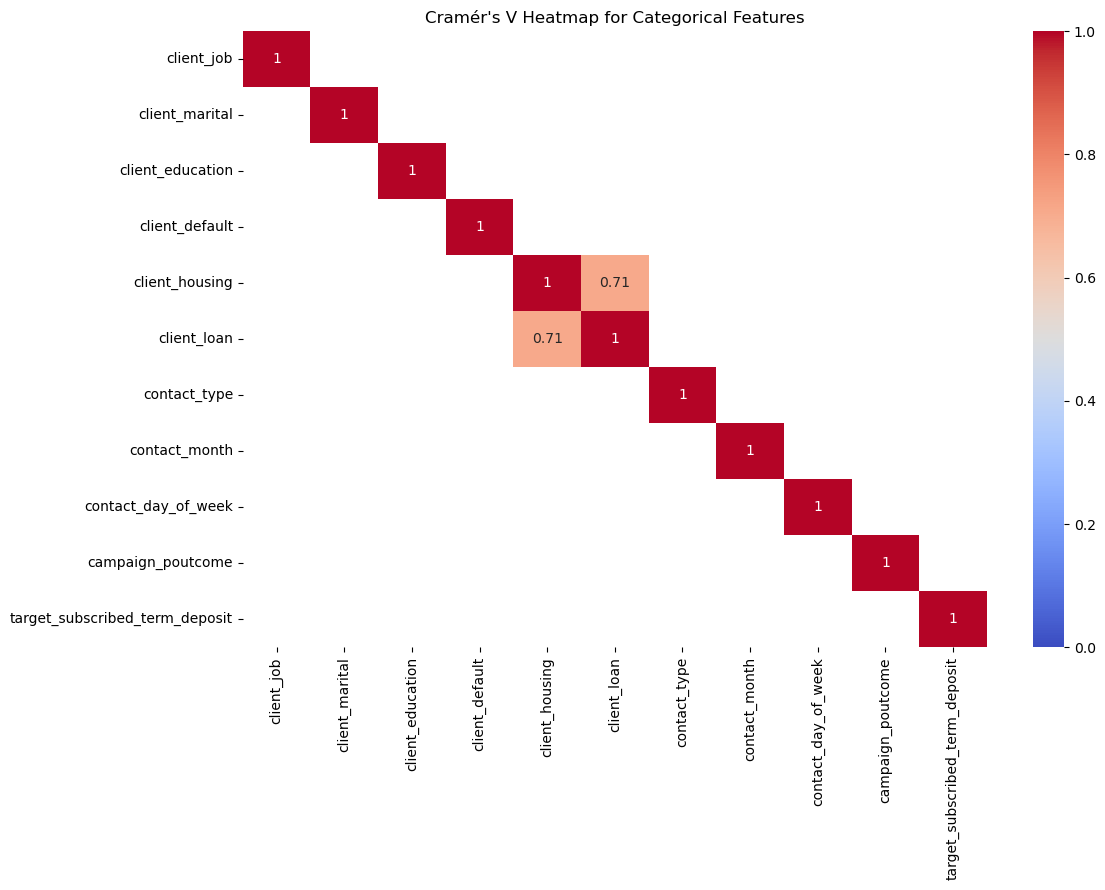

In [21]:
#  Cramér's V for categorical features

# define Function to calculate Cramér's V
def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    r, k = contingency_table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

categorical_features = df.select_dtypes(include=['category','object'])

# Calculate Cramér's V for each pair of categorical features
categories = categorical_features.columns
cramers_v_matrix = pd.DataFrame(index=categories, columns=categories)

for col1 in categories:
    for col2 in categories:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            contingency_table = pd.crosstab(categorical_features[col1], categorical_features[col2])
            if cramers_v(contingency_table)>0.65:
                cramers_v_matrix.loc[col1, col2] = cramers_v(contingency_table)

cramers_v_matrix = cramers_v_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Heatmap for Categorical Features")
plt.savefig('images/CramerCategoricalFeat.jpg')
plt.show()

In [22]:
# Creating df2 from df applyng what have learned about features from previous analysis

df2 = df.drop(columns=['client_housing', 'context_cons_price_idx', 'context_euribor3m', 'context_nr_employed', 'contact_duration', 'client_default']).copy()
categorical_features = df2.select_dtypes(include=['object']).columns
df2 = df2[~df2[categorical_features].apply(lambda x: x.str.contains('unknown')).any(axis=1)].copy()

In [23]:
#df2.head()
#print(df2.isna().sum() > 0)
#print(df2.isnull().sum()> 0)

In [24]:
#Make the preprocessor transformer

X = df2.drop(columns=['target_subscribed_term_deposit'], axis=1)
y = df2['target_subscribed_term_deposit']
le = LabelEncoder()
y = le.fit_transform(y)

numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()
#ordinal_transformer = OrdinalEncoderCustom(mappings=ordinal_mappings)

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        #('ord', ordinal_transformer, ordinal_features)
    ]
)

In [25]:
# create train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [26]:
#print(X_test.isna().sum() > 0)
#print(X_test.isnull().sum()> 0)

In [27]:

# Create pipeline, classifiers, param grid to apply grid search cv

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

classifiers = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC()
}

# Define parameter grid for GridSearchCV
param_grid = [
    {
        'classifier': [classifiers['Logistic Regression']],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__solver': ['lbfgs'],
        'classifier__class_weight': ['balanced'],
        'classifier__max_iter': [1000]
    },
    {
        'classifier': [classifiers['SVM']],
        'classifier__C': [1, 3, 5],
        'classifier__kernel': ['rbf'],
        'classifier__class_weight': ['balanced'],
    }
]


# Set up GridSearchCV with F1-score as the metric for optimization
grid_search = GridSearchCV(pipeline_1, param_grid, cv=5, scoring='recall', verbose=2, n_jobs=-1, return_train_score=True)

grid_search.fit(X_train,y_train)

#best_model = grid_search.best_estimator_
#print("Miglior modello:", best_model)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['client_age', 'campaign_contacts', 'campaign_pdays',
       'campaign_previous_contacts', 'context_emp_var_rate',
       'context_cons_conf_idx'],
      dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['client_job', 'client_marital', 'client_edu...
             param_grid=[{'classifier': [LogisticRegression()],
                          'classifier__C': [0.1, 1, 10, 100],
                          'classifier__class_weight': ['balanced'],
                          'classifier__max_iter': [1000],
                          'classifier__solver': ['lbfgs']},
                         {'classifier': [SVC()], 'classifier__C': [1, 3, 5],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['rbf']}],
             return_train_score=True, scoring='recall', verbose=2)

In [28]:
# Calculate scoring

y_train_pred_opt = grid_search.best_estimator_.predict(X_train)
y_test_pred_opt = grid_search.best_estimator_.predict(X_test)

train_accuracy_opt = accuracy_score(y_train, y_train_pred_opt)
test_accuracy_opt = accuracy_score(y_test, y_test_pred_opt)
    
precision_train_opt = precision_score(y_train, y_train_pred_opt, pos_label=1)
precision_test_opt = precision_score(y_test, y_test_pred_opt, pos_label=1)
    
recall_train_opt = recall_score(y_train, y_train_pred_opt, pos_label=1)
recall_test_opt = recall_score(y_test, y_test_pred_opt, pos_label=1)
    
f1_train_opt = f1_score(y_train, y_train_pred_opt, pos_label=1)
f1_test_opt = f1_score(y_test, y_test_pred_opt, pos_label=1)

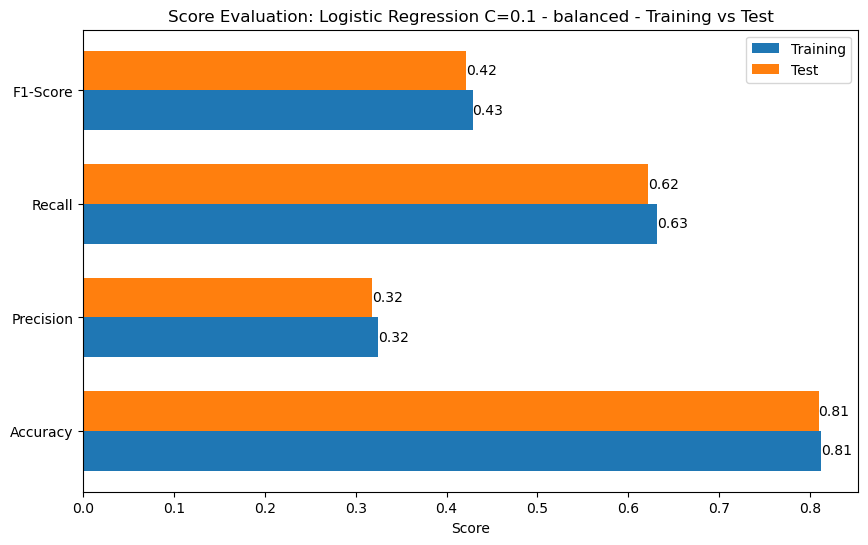

In [29]:
#Make plot for scoring analysis

# Make a dictionary
metrics = {
    'Accuracy': [train_accuracy_opt, test_accuracy_opt],
    'Precision': [precision_train_opt, precision_test_opt],
    'Recall': [recall_train_opt, recall_test_opt],
    'F1-Score': [f1_train_opt, f1_test_opt]
}

# Index for bars
labels = ['Training', 'Test']
bar_width = 0.35  # Larghezza delle barre

# Bar Positions
index = np.arange(len(metrics))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

train_bars = ax.barh(index - bar_width/2, [metrics[m][0] for m in metrics], bar_width, label='Training')
test_bars = ax.barh(index + bar_width/2, [metrics[m][1] for m in metrics], bar_width, label='Test')
ax.set_xlabel('Score')
ax.set_title('Score Evaluation: Logistic Regression C=0.1 - balanced - Training vs Test')
ax.set_yticks(index)
ax.set_yticklabels(metrics.keys())
ax.legend()

for bar in train_bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

for bar in test_bars:
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', va='center')

plt.savefig('images/OptimalModel.jpg')
plt.show()

In [30]:
#Select the more important 10 features with values

best_pipeline = grid_search.best_estimator_
best_classifier = best_pipeline.named_steps['classifier']

feature_importances = best_classifier.coef_[0]  # Per problemi binari
    
fitted_preprocessor = best_pipeline.named_steps['preprocessor']
feature_names = fitted_preprocessor.get_feature_names_out()
    
feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
    
feature_importance_df.head(10)

,Feature,Importance
30,cat__contact_month_mar,1.092380
39,cat__campaign_poutcome_nonexistent,0.620576
33,cat__contact_month_oct,0.601683
40,cat__campaign_poutcome_success,0.515455
34,cat__contact_month_sep,0.482152
13,cat__client_job_student,0.372759
10,cat__client_job_retired,0.371795
28,cat__contact_month_jul,0.239465
23,cat__client_education_university.degree,0.162210
21,cat__client_education_illiterate,0.136367


### Final consideration on features to use to develop a good strategy

**Contact Months** : The months of contact (particularly March, October, September, and July) seem to be key factors in the decision to sign for the investment. This could be linked to seasonal variables or specific marketing or promotional initiatives carried out during those months.

**Outcome of Previous Campaigns**: If clients have not participated in previous campaigns or had a successful outcome, they are more likely to sign. New clients or those with positive experiences are probably less skeptical about new investments.

**Occupation**: Occupations such as "students" and "retirees" appear more likely to sign for an investment. This may reflect a greater openness among these categories, possibly looking to build their capital or manage it more securely.

**Education Level**: People with a university degree have a higher probability of investing, as one might expect, since they may be more familiar with investment opportunities. However, the positive probability for "illiterate" individuals could suggest that other factors are at play (such as the support of financial advisors).